In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:teslaV100s:1 ./ctct_dense16.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
save_dir = '/home/was966/Research/mims-compass/paper/'
pretrainer = loadcompass(os.path.join(save_dir, 'checkpoint/latest/pretrainer.pt'))

data_path = os.path.join(save_dir, '00_data')
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

In [3]:
cohort_X = dfcx
cohort_y = df_task

params = {'mode': 'LFT',
        'seed':42,
        'lr': 1e-3,
        'device':'cuda',
        'weight_decay': 1e-4,
        'batch_size':96, 
        'max_epochs': 500,
        'task_loss_weight':1,
        'load_decoder':False,
        'task_loss_type': 'ce_loss', 
        'task_type': 'c',
        'task_dense_layer': [16],
        'task_batch_norms':True,
        'entropy_weight': 0.0,
        'with_wandb': False,
        'save_best_model':False,
        'verbose': False}

In [4]:
res = []
work_dir = './PT_LFT'
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

pretrainer = pretrainer.copy()
finetuner = FineTuner(pretrainer, **params, 
                      work_dir= work_dir, 
                      task_name = 'LFT')
finetuner = finetuner.tune(dfcx_train = cohort_X,
                           dfy_train = cohort_y, min_mcc=0.85)

 47%|####6     | 233/500 [34:02<38:59,  8.76s/it] 

Stopping early at epoch 234. Meet minimal requirements by: f1=0.90,mcc=0.86,prc=0.87, roc=0.91


In [5]:
pred_testy = finetuner.predict(cohort_X,batch_size=16)

100%|##########| 71/71 [00:03<00:00, 19.89it/s]


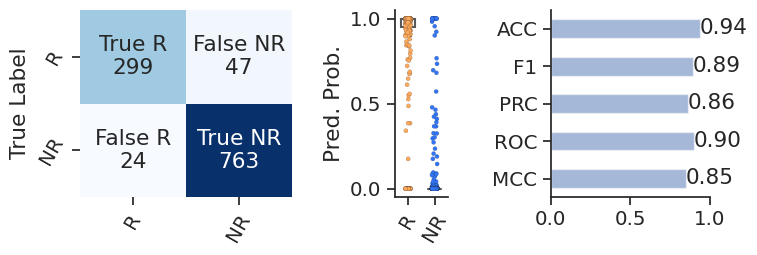

In [6]:
#pd.DataFrame(finetuner.performance)[4].plot()
dfp = cohort_y.join(pred_testy)

y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
fig = plot_performance(y_true, y_prob, y_pred)

<Axes: >

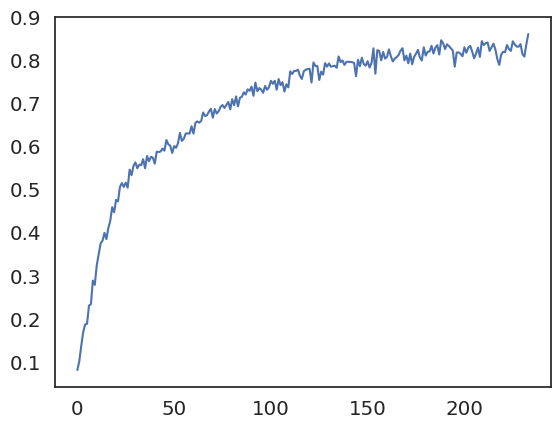

In [7]:
pd.DataFrame(finetuner.performance)[2].plot()

In [9]:
finetuner.save(os.path.join(save_dir, 'checkpoint/latest/finetuner_lft_all.pt' ))

Saving the model to /home/was966/Research/mims-conceptor/paper/checkpoint/latest/finetuner_lft_all_rxt8000.pt
